In [34]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
import scipy.optimize
import scipy.stats
from scipy.special import expit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.datasets import make_moons

In [101]:
np.random.seed(123)

# Produce data

In [102]:
def u(x, alpha):
    return x**(1 - alpha)

In [103]:
steps = np.linspace(0.01,0.99, 10)
task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]
task.reset_index(inplace=True, drop=True)
task
# task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
# task

,p0,x0,p1,x1
0,0.01,0.118889,0.118889,0.01
1,0.01,0.118889,0.227778,0.01
2,0.01,0.118889,0.336667,0.01
3,0.01,0.118889,0.445556,0.01
4,0.01,0.118889,0.554444,0.01
...,...,...,...,...
4045,0.99,0.881111,0.445556,0.99
4046,0.99,0.881111,0.554444,0.99
4047,0.99,0.881111,0.663333,0.99
4048,0.99,0.881111,0.772222,0.99


In [104]:
n_trial = len(task)

tau = 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

p_choice_1 = scipy.stats.norm.cdf(seu1 - seu0) # expit((seu1 - seu0)/tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice
task

,p0,x0,p1,x1,choice
0,0.01,0.118889,0.118889,0.01,0
1,0.01,0.118889,0.227778,0.01,1
2,0.01,0.118889,0.336667,0.01,1
3,0.01,0.118889,0.445556,0.01,0
4,0.01,0.118889,0.554444,0.01,0
...,...,...,...,...,...
4045,0.99,0.881111,0.445556,0.99,1
4046,0.99,0.881111,0.554444,0.99,0
4047,0.99,0.881111,0.663333,0.99,1
4048,0.99,0.881111,0.772222,0.99,0


# Model-based

In [105]:
def objective(param, task, fixed_param):
    
    alpha, = param
    tau,  = fixed_param
            
    seu0 = task.p0 * u(task.x0, alpha=alpha)
    seu1 = task.p1 * u(task.x1, alpha=alpha)
    
    p_choice = np.zeros((2, len(task)))
    p_choice[1] = scipy.stats.norm.cdf(seu1-seu0) #expit((seu1 - seu0) / tau)
    p_choice[0] = 1 - p_choice[1]

    ll = np.concatenate((p_choice[0, task.choice == 0], p_choice[1, task.choice == 1]))
    return - np.log(ll+np.finfo(float).eps).sum()

In [106]:
# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=(0, ),
    bounds=((0., None), ),
    args=(task, (tau, )),
    method='L-BFGS-B')
res

      fun: 2749.878751364924
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.54747351e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.40963999])

In [107]:
alpha_pred, = res.x

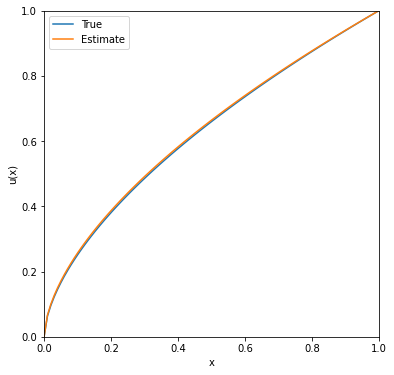

In [108]:
# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

x_pred = np.linspace(0, 1, 100)

# Plot 
ax.plot(x_pred, u(x_pred, true_alpha), label="True")
ax.plot(x_pred, u(x_pred, alpha_pred), label="Estimate")

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.legend()
plt.show()

# Model-free coordinate estimates

In [112]:
def objective(param, task, fixed_param):
    
    # cov = kernel(X, X)
    
    uniq_x = np.unique(np.concatenate((task.x0, task.x1)))
    fx = dict(zip(uniq_x, param))
    
    n_trial = len(task)
    
    tau,  = fixed_param
            
    seu0 = task.p0 * np.array([fx[task.x0.values[i]] for i in range(n_trial)])
    seu1 = task.p1 * np.array([fx[task.x1.values[i]] for i in range(n_trial)])
    
    p_choice = np.zeros((2, len(task)))
    p_choice[1] = scipy.stats.norm.cdf(seu1-seu0) # expit((seu1 - seu0) / tau)
    p_choice[0] = 1 - p_choice[1]

    ll = np.concatenate((p_choice[0, task.choice == 0], p_choice[1, task.choice == 1]))
    return - np.log(ll+np.finfo(float).eps).sum()

In [123]:
uniq_x = np.unique(np.concatenate((task.x0, task.x1)))
n_uniq_x = len(uniq_x)
print("n unique x: ", n_uniq_x)
bounds = [(0., 1.) for _ in range(n_uniq_x)]
x0 = [x for x in uniq_x]

# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=x0,
    bounds=bounds,
    args=(task, (tau, )),
    method='L-BFGS-B')
res

n unique x:  10


      fun: 2746.984537523107
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00127329, -0.00304681, -0.00100044,  0.00568434,  0.0007276 ,
       -0.00086402, -0.00186446, -0.00045475,  0.00045475, -0.0001819 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 143
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([0.04270144, 0.27400585, 0.41653706, 0.45009245, 0.5478734 ,
       0.54064897, 0.69431478, 0.83173443, 0.76483793, 0.80516373])

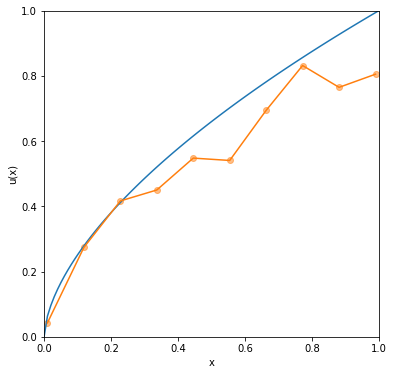

In [125]:
# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot estimate
ax.plot(x_pred, u(x_pred, true_alpha), label="True")
ax.plot(steps, res.x, label="Estimate")

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((steps, res.x))
ax.scatter(coord[0], coord[1], alpha=0.5, color='C1')

plt.show()

In [170]:
kernel = RBF() #ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=0, alpha=0.001)

In [171]:
# Fit to data using Maximum Likelihood Estimation of the parameters
X = np.atleast_2d(steps).T
fit = gp.fit(X, res.x)

In [172]:
Xpred = np.atleast_2d(x_pred).T

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(Xpred, return_std=True)

# Create samples of functions
y_samples = gp.sample_y(Xpred, 10)

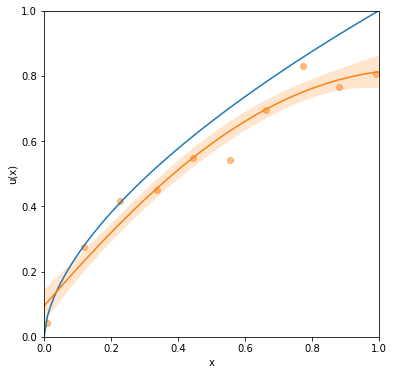

In [173]:
# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot
ax.plot(x_pred, u(x_pred, true_alpha), label="True")

# Difference is there!
ax.plot(x_pred, y_pred, label="Estimate")

ax.fill_between(x_pred, y_pred + 1.96 * sigma, y_pred - 1.96 * sigma,
         alpha=.2, fc='C1', ec='None', label='95% confidence interval')

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((steps, res.x))
ax.scatter(coord[0], coord[1], alpha=0.5, color='C1')

plt.show()

# Gaussian process

In [174]:
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task

,p0,x0,p1,x1
0,0.662163,0.482455,0.068930,0.767339
1,0.476015,0.292602,0.170036,0.614539
2,0.924166,0.264374,0.874595,0.663484
3,0.018290,0.849445,0.396082,0.844821
4,0.198981,0.518572,0.205034,0.489327
...,...,...,...,...
995,0.610637,0.617551,0.914602,0.218826
996,0.510169,0.999375,0.378944,0.906704
997,0.690840,0.644433,0.140883,0.770336
998,0.078791,0.172665,0.807574,0.491974


In [176]:
n_trial = len(task)

tau = 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

p_choice_1 = scipy.stats.norm.cdf(seu1 - seu0) # expit((seu1 - seu0)/tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice
task

,p0,x0,p1,x1,choice
0,0.662163,0.482455,0.068930,0.767339,0
1,0.476015,0.292602,0.170036,0.614539,0
2,0.924166,0.264374,0.874595,0.663484,1
3,0.018290,0.849445,0.396082,0.844821,1
4,0.198981,0.518572,0.205034,0.489327,0
...,...,...,...,...,...
995,0.610637,0.617551,0.914602,0.218826,1
996,0.510169,0.999375,0.378944,0.906704,0
997,0.690840,0.644433,0.140883,0.770336,1
998,0.078791,0.172665,0.807574,0.491974,1


In [197]:
def objective(param, task, steps, fixed_param):
    
    kernel = RBF() #ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

    # Instantiate a Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel,
                                  n_restarts_optimizer=0, alpha=0.001)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    X = np.atleast_2d(steps).T
    fit = gp.fit(X, param)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    u0 = gp.predict(np.atleast_2d(task.x0.values).T, return_std=False)
    u1 = gp.predict(np.atleast_2d(task.x1.values).T, return_std=False)
    
    seu0 = task.p0 * u0
    seu1 = task.p1 * u1
    
    #     tau,  = fixed_param
    p_choice = np.zeros((2, len(task)))
    p_choice[1] = scipy.stats.norm.cdf(seu1-seu0) # expit((seu1 - seu0) / tau)
    p_choice[0] = 1 - p_choice[1]

    ll = np.concatenate((p_choice[0, task.choice == 0], p_choice[1, task.choice == 1]))
    loss = - np.log(ll+np.finfo(float).eps).sum()
    return loss

In [198]:
bounds = [(0., 1.) for _ in range(len(steps))]
x0 = steps.copy()

fixed_param = (tau, )

# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=x0,
    bounds=bounds,
    args=(task, steps, fixed_param),
    method='L-BFGS-B')
res

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

      fun: 653.9486362822222
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.28892373,  0.80733571, -1.55816906, -0.45997694,  2.83450844,
        1.21655148, -0.50918061,  2.38449046,  1.2993496 , -6.07208218])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 550
      nit: 4
     njev: 50
   status: 2
  success: False
        x: array([0.        , 0.        , 0.43652065, 0.63985916, 0.73381026,
       0.79481651, 0.85508881, 0.85895252, 0.92465724, 0.90574377])

In [207]:
kernel = RBF() #ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=0, alpha=0.01)

In [208]:
# Fit to data using Maximum Likelihood Estimation of the parameters
X = np.atleast_2d(steps).T
fit = gp.fit(X, res.x)

In [209]:
Xpred = np.atleast_2d(x_pred).T

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(Xpred, return_std=True)

# Create samples of functions
y_samples = gp.sample_y(Xpred, 10)

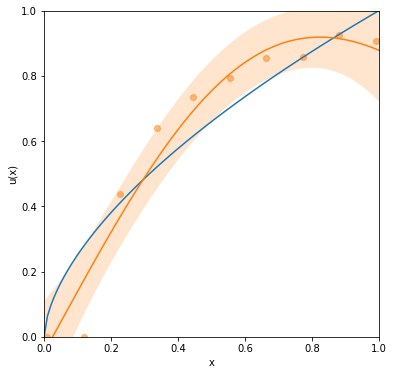

In [210]:
# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot
ax.plot(x_pred, u(x_pred, true_alpha), label="True")

# Difference is there!
ax.plot(x_pred, y_pred, label="Estimate")

ax.fill_between(x_pred, y_pred + 1.96 * sigma, y_pred - 1.96 * sigma,
         alpha=.2, fc='C1', ec='None', label='95% confidence interval')

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((steps, res.x))
ax.scatter(coord[0], coord[1], alpha=0.5, color='C1')

plt.show()

In [196]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def objective(param, task, fixed_param):
    
    # cov = kernel(X, X)
    
    uniq_x = np.unique(np.concatenate((task.x0, task.x1)))
    fx = dict(zip(uniq_x, param))
    
    n_trial = len(task)
    
    tau,  = fixed_param
            
    seu0 = task.p0 * np.array([fx[task.x0.values[i]] for i in range(n_trial)])
    seu1 = task.p1 * np.array([fx[task.x1.values[i]] for i in range(n_trial)])
    
    p_choice = np.zeros((2, len(task)))
    p_choice[1] = scipy.stats.norm.cdf(seu1-seu0) # expit((seu1 - seu0) / tau)
    p_choice[0] = 1 - p_choice[1]

    ll = np.concatenate((p_choice[0, task.choice == 0], p_choice[1, task.choice == 1]))
    return - np.log(ll+np.finfo(float).eps).sum()

uniq_x = np.unique(np.concatenate((task.x0, task.x1)))
n_uniq_x = len(uniq_x)
print("n unique x: ", n_uniq_x)
bounds = [(0., 1.) for _ in range(n_uniq_x)]
x0 = [x for x in uniq_x]

# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=x0,
    bounds=bounds,
    args=(task, (tau, )),
    method='L-BFGS-B')
res

# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot estimate
ax.plot(x_pred, u(x_pred, true_alpha), label="True")
ax.plot(steps, res.x, label="Estimate")

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((steps, res.x))
ax.scatter(coord[0], coord[1], alpha=0.5, color='C1')

plt.show()

n unique x:  2000


KeyboardInterrupt: 

In [109]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

# 2-D

In [35]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return theta[1] ** 2 * np.exp(-0.5 / theta[0] ** 2 * sqdist)

In [36]:
def K_(X, theta, diag_only=False, nu=1e-5):
    """Helper to apply kernel function."""
    if diag_only:
        # Specific solution for isotropic 
        # squared exponential kernel.
        return theta[1] ** 2 + nu
    else:
        return kernel(X, X, theta) + nu * np.eye(X.shape[0])

def W_(a):
    """Helper to compute matrix W."""
    r = expit(a) * (1 - expit(a))
    return np.diag(r.ravel())

In [37]:
def posterior_mode(X, t, K_a, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(a|t).
    """
    a_h = np.zeros_like(t)
    I = np.eye(X.shape[0])

    for i in range(max_iter):
        W = W_(a_h)
        Q_inv = np.linalg.inv(I + W @ K_a)
        a_h_new = (K_a @ Q_inv).dot(t - expit(a_h) + W.dot(a_h))
        a_h_diff = np.abs(a_h_new - a_h)
        a_h = a_h_new

        if not np.any(a_h_diff > tol):
            break

    return a_h

In [38]:
def nll_fn(X, t):
    """
    Returns the negative log-likelihood function for data X, t.
    """
    
    t = t.ravel()

    def nll(theta):
        K_a = K_(X, theta)
        K_a_inv = np.linalg.inv(K_a)

        # posterior mode depends on theta (via K)
        a_h = posterior_mode(X, t, K_a).ravel()
        W = W_(a_h)

        ll = - 0.5 * a_h.T.dot(K_a_inv).dot(a_h) \
             - 0.5 * np.linalg.slogdet(K_a)[1] \
             - 0.5 * np.linalg.slogdet(W + K_a_inv)[1] \
             + t.dot(a_h) - np.sum(np.log(1.0 + np.exp(a_h)))

        return -ll

    return nll

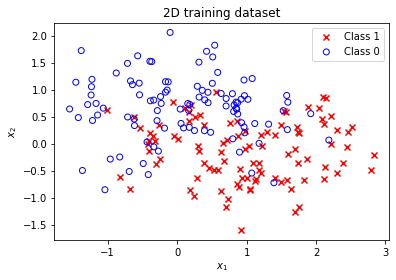

In [39]:
X, t = make_moons(200, noise=0.5, random_state=1)
t = t.reshape(-1, 1)

class_1 = np.ravel(t == 1)
class_0 = np.ravel(t == 0)

plt.scatter(X[class_1, 0], X[class_1, 1], label='Class 1', marker='x', c='red')
plt.scatter(X[class_0, 0], X[class_0, 1], label='Class 0', marker='o', edgecolors='blue', facecolors='none')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.title('2D training dataset')
plt.legend();

In [40]:
res = scipy.optimize.minimize(nll_fn(X, t), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

Optimized theta = [1.376, 3.386], negative log likelihood = 93.439
